# DOG BREED PREDICTION

In this project, we will see how to use Keras and TensorFlow to build, train, and test a Convolutional Neural Network capable of identifying the breed of a dog in a supplied image. This is a supervised learning problem, specifically a multiclass classification problem.

We will start by connecting to Kaggle using Kaggle API which can be downloaded from your Kaggle account's settings and uploading it here(upload box).

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gdhall","key":"16c7d999a4d80268834c5e8ad11a2ce5"}'}

In [2]:
!pip install -q kaggle

Next we will install Kaggle API using pip installation.

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [5]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           5867          8  0.1764706        


To store the data we will create a new directory and make it as current working directory.

In [6]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
 98% 679M/691M [00:08<00:00, 82.0MB/s]
100% 691M/691M [00:08<00:00, 87.1MB/s]
/root


We will unzip the data which is downloaded and remove the irrelevant files.

In [10]:
import os
import zipfile

# Ensure the directory exists
os.makedirs('dog_dataset', exist_ok=True)

# Download the dataset
os.system('kaggle datasets download -d catherinehorng/dogbreedidfromcomp -p dog_dataset')

# Define the zip file path
zip_file_path = 'dog_dataset/dogbreedidfromcomp.zip'

# Check if the file exists before attempting to unzip
if os.path.exists(zip_file_path):
    # Unzip the dataset
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('dog_dataset')

    # Remove the zip file
    os.remove(zip_file_path)
else:
    print(f"Zip file {zip_file_path} not found.")


Importing required libraries.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

Loading the labels data into dataframe and viewing it. Here we analysed that labels contains 10222 rows and 2 columns

In [14]:
labels_all=pd.read_csv('dog_dataset/labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Here we are finding out the count per class i.e. total data in each class using value_counts() function

In [15]:
breed_all = labels_all['breed']
breed_counts=breed_all.value_counts()
breed_counts.head()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64

We will work on only 3 breeds due to limited computational power. You can consider more classes as per your system computational power.

In [16]:
class_names = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(class_names))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


As we are working with the classification dataset first we need to one hot encode the target value i.e. the classes. After that we will read images and convert them into numpy array and finally normalizing the array.

In [19]:
X_data= np.zeros((len(labels),224,224,3), dtype='float32')
#One Hot Encoding
Y_data= label_binarize(labels['breed'], classes = class_names)


for i in tqdm(range(len(labels))):
  img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224,224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(),axis=0)
  X_data[i] = x / 255.0



print('\nTrain Images Shape:',X_data.shape,'size: {:,}'.format(X_data.size))
print('one hot encoded output Shape:',Y_data.shape,'size: {:,}'.format(Y_data.size))



100%|██████████| 357/357 [00:03<00:00, 97.24it/s]


Train Images Shape: (357, 224, 224, 3) size: 53,738,496
one hot encoded output Shape: (357, 3) size: 1,071


In [31]:
import tensorflow as tf

Next we will create a network architecture for the model. We have used different types of layers according to their features namely Conv_2d (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor), max_pooling2d (It is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten (It flattens the input and creates a 1D output), Dense (Dense layer produce the output as the dot product of input and kernel).

In [32]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size = (5,5), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size = (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size = (7,7), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=8, kernel_size = (5,5), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(len(class_names), activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()







Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 110, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 24, 24, 16)       

After defining the network architecture we found out the total parameters as 162,619.

After defining the network architecture we will start with splitting the test and train data then dividing train data in train and validation data.

In [33]:
X_train_and_val,X_test,y_train_and_val,y_test = train_test_split(X_data, Y_data, test_size=0.1)

X_train,X_val,y_train,y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.2)

Now we will train our model on 100 epochs and a batch size of 128. You can try using more number of epochs to increase accuracy. During each epochs we can see how the model is performing by viewing the training and validation accuracy.

In [34]:
epochs = 50
batch_size = 128


history = model.fit(X_train,y_train,batch_size = batch_size,epochs=epochs, validation_data=(X_val,y_val))

Epoch 1/50
2/2 [==============================] - 52s 24s/step - loss: 4.8889 - accuracy: 0.3125 - val_loss: 4.8680 - val_accuracy: 0.3846
Epoch 2/50
2/2 [==============================] - 37s 20s/step - loss: 4.8578 - accuracy: 0.4141 - val_loss: 4.8400 - val_accuracy: 0.4000
Epoch 3/50
2/2 [==============================] - 39s 20s/step - loss: 4.8297 - accuracy: 0.4414 - val_loss: 4.8132 - val_accuracy: 0.4000
Epoch 4/50
2/2 [==============================] - 41s 23s/step - loss: 4.8021 - accuracy: 0.4062 - val_loss: 4.7881 - val_accuracy: 0.4000
Epoch 5/50
2/2 [==============================] - 37s 20s/step - loss: 4.7760 - accuracy: 0.4062 - val_loss: 4.7643 - val_accuracy: 0.4000
Epoch 6/50
2/2 [==============================] - 39s 19s/step - loss: 4.7497 - accuracy: 0.4102 - val_loss: 4.7408 - val_accuracy: 0.3846
Epoch 7/50
2/2 [==============================] - 39s 22s/step - loss: 4.7232 - accuracy: 0.4141 - val_loss: 4.7171 - val_accuracy: 0.4000
Epoch 8/50
2/2 [===========

Here we analyse how the model is learning with each epoch in terms of accuracy.

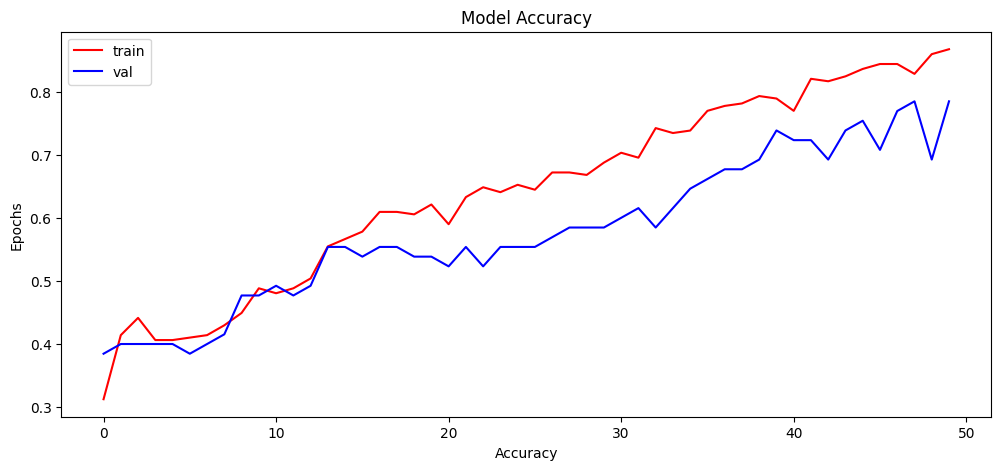

In [35]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.title('Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend(['train','val'])

plt.show()

We will use predict function to make predictions using this model also we are finding out the accuracy on the test set.

In [36]:
y_pred= model.predict(X_test)
score=model.evaluate(X_test,y_test)
print('Accuracy over the test set: \n',round((score[1]*100),2), '%')

2/2 [==============================] - 2s 138ms/step - loss: 3.6366 - accuracy: 0.7222
Accuracy over the test set: 
 72.22 %


Here you can see image with its original and predicted label.

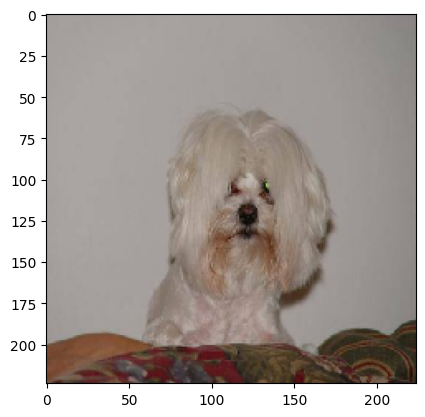

Originally : maltese_dog
predicted : maltese_dog


In [43]:
plt.imshow(X_test[20,:,:,:])
plt.show()

print('Originally :', labels['breed'][np.argmax(y_test[20])])
print('predicted :', labels['breed'][np.argmax(y_pred[20])])

# Conclusion

We started with downloading the dataset creating the model and finding out the predictions using the model. We can optimize different hyper parameters in order to tune this model for a higher accuracy. This model can be used to predict different breeds of dogs which can be further used by different NGO's working on saving animals and for educational purposes also.